In [124]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
from statistics import mean
from scipy.optimize import curve_fit

sys.path.insert(0, './radiometric')
sys.path.insert(0, './radiometric')
from LUT_functions import pixel_registration, create_LUT_df
import scipy

# Seaborn for plotting and styling
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid", {'axes.grid' : False})

In [125]:
#choose filepath to desired data
cal_file1 =  "/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_files/cam1pixel.h5"
cal_file2 =  "/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_files/cam2pixel.h5"

In [126]:
path = '/Users/kirahart/Dropbox/GitHub/IRCSP2_data/Cal_target_analysis/dec16/'

df1 = create_LUT_df(path,'cam1_right.h5')
df2 = create_LUT_df(path,'cam2_right.h5')

In [127]:
waves= np.linspace(7,12,61)
angles = np.round(np.linspace(-7.07,7.07,35),1)

In [128]:
#import nuc calibration
sys.path.insert(0, './NUC')
from NUC_functions import import_NUC, apply_NUC
cal_path = '/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_files/NUC.h5'

m1,b1,T_ref1,m2,b2,T_ref2 = import_NUC(cal_path)

In [129]:
#apply pixel registration and NUC to full dataset

ymin1 = 105; ymax1 = 140;
ymin2 = 130; ymax2 = 165;

mean_ims1 =[]
mean_ims2 =[]
std_ims1  =[]
std_ims2  =[]

corrected_images1= [] ; corrected_images1n= [];
corrected_images2= [] ; corrected_images2n= []


for i in range(len(df1)):
     #first without NUC correction
    r = df1['images1'][i];
    c = pixel_registration(r,cal_file1,waves,ymin1,ymax1)
        
    corrected_images1.append(c)
       

for i in range(len(df1)):
    #first without NUC correction
    r = df2['images1'][i];
    c = pixel_registration(r,cal_file2,waves,ymin2,ymax2)
        
        
    corrected_images2.append(c)
    

mean_ims1.append(np.mean(corrected_images1,axis = 0))
mean_ims2.append(np.mean(corrected_images2,axis = 0))

std_ims1.append(np.std(corrected_images1,axis = 0))
std_ims2.append(np.std(corrected_images2,axis = 0))

In [130]:
d = {'ims1': list(mean_ims1),'s1': list(std_ims1), 'ims2':list(mean_ims2),'s2': list(std_ims2)}

In [131]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()
df

,ims1,s1,ims2,s2
0,"[[23020.885, 23028.635, 23028.88, 23027.74, 23...","[[9.057277460694257, 6.492247299664412, 9.0961...","[[22526.63, 22523.69, 22520.665, 22527.63, 225...","[[6.655681783258567, 6.174050534292701, 5.8271..."


In [71]:
def finv(y,A,B):
    return ((y-B)/A)**0.5


In [132]:
#create sum column
df["totalrad"] = df['ims2']+df['ims1']
df["totalstd"] = (df['s2']**2+df['s1']**2)**0.5

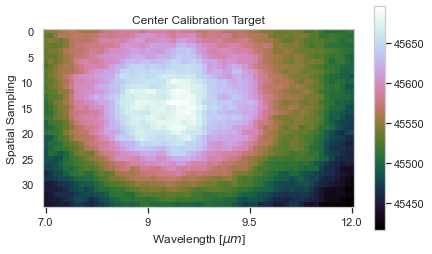

In [146]:
cmin = np.min(list(df['totalrad'])); cmax=np.max(list(df['totalrad']))

j = 0;
plt.matshow(df['totalrad'][j],cmap = 'cubehelix' )
plt.colorbar()
plt.ylabel('Spatial Sampling')
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.title('Center Calibration Target')
#plt.clim(cmin,cmax)
plt.show()

In [134]:
# pixel fit 
def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x**2 + B

def finv(y,A,B):
    return ((y-B)/A)**0.5


In [135]:
def get_slice(df,x,y):
    sli = []
    for i in range(len(df)):
        s = df[i]
        sli.append(s[y,x])
    return(sli)

def get_slice_avg(df,x):
    sli = []
    for i in range(len(df)):
        s = df[i]
        sli.append(np.mean(s[:,x]))
    return(sli)

In [136]:
#import radiometric data

#choose filepath to desired data
save_path =   '/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_files/'
name =  "LUT.h5" 

coef_df=create_LUT_df(save_path,name)

In [89]:
def radiometric_retrieval(df,j,At,Bt):
    #attempt retrival
    Ts= np.zeros([35,len(waves)])
    for w in range(len(waves)):
        for s in range(35):
            data=(np.array(df['ims1'])+np.array(df['ims2']))[0][s][w]
            A = At[s][w]
            B = Bt[s][w]
            t = finv(data,A,B)
            Ts[s][w] = t
    return(Ts) 

def radiometric_retrieval_single(df,j,At,Bt):
    #attempt retrival
    Ts= np.zeros([35,len(waves)])
    for w in range(len(waves)):
        for s in range(35):
            data=(df[0])[s][w]
            A = At[s][w]
            B = Bt[s][w]
            t = finv(data,A,B)
            Ts[s][w] = t
    return(Ts)        

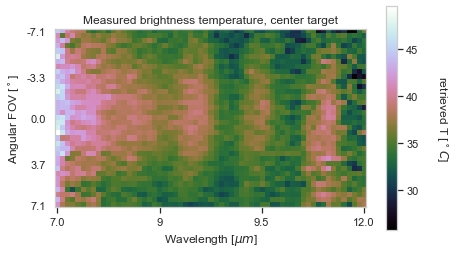

In [176]:
j =0;
Ts = radiometric_retrieval(df,j,np.array(coef_df['At']),np.array(coef_df['Bt'])) 


plt.matshow(Ts,cmap = 'cubehelix' )
cbar = plt.colorbar()
cbar.set_label('retrieved T [$^\circ C$]\n', rotation=-90, va="bottom")
plt.ylabel('Angular FOV [$^\circ$]')
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.yticks([0, 9,17,26,34], [angles[0], angles[9],angles[17],angles[26],angles[34]])
plt.title('Measured brightness temperature, center target')
#plt.clim(0,temps[j]+5)
plt.show()


In [188]:
At= coef_df['A2']
Bt=coef_df['B2']

Ts2= np.zeros([35,len(waves)])
for w in range(len(waves)):
    for s in range(35):
        data=(df['ims2'][0])[s][w]
        A = coef_df['A2'][s][w]
        B = coef_df['B2'][s][w]
        t = finv(data,A,B)
        Ts2[s][w] = t
        
Ts1= np.zeros([35,len(waves)])
for w in range(len(waves)):
    for s in range(35):
        data=(df['ims1'][0])[s][w]
        A = coef_df['A1'][s][w]
        B = coef_df['B1'][s][w]
        t = finv(data,A,B)
        Ts1[s][w] = t        

<ipython-input-134-13cc28e3c46d>:6: RuntimeWarning: invalid value encountered in double_scalars
  return ((y-B)/A)**0.5


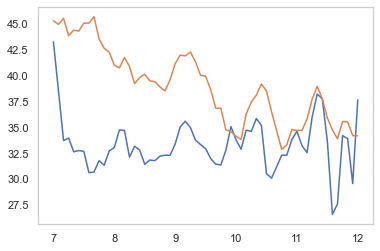

In [200]:
plt.plot(waves, Ts1[10])
plt.plot(waves, Ts2[10])